In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

ETL dataset

In [2]:
# Read a CSV file into a DataFrame
csv_file_path = "../Dataset/XRPUSDT/XRPUSDT_5min.csv"  # Replace with your CSV file path
xrp_df = pd.read_csv(csv_file_path)

In [3]:
def checkCrossOver(macd, signal_line):
    if macd > signal_line: 
        return 1
    elif macd < signal_line: 
        return -1
    else: 
        return 0

In [4]:
def getATR(df, period):
    # Calculate the True Range (TR)
    df['high_low'] = df['high'] - df['low']
    df['high_close'] = abs(df['high'] - df['close'].shift())
    df['low_close'] = abs(df['low'] - df['close'].shift())
    df['tr'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)

    # Calculate the Average True Range (ATR)
    df['atr'] = df['tr'].rolling(window=period).mean()

    return df

In [5]:
def getADX(df, period):
    high = df['high']
    low  = df['low']

    plus_dm = high.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm = low.diff()
    minus_dm[minus_dm > 0] = 0

    tmp_df = df.copy()
    atr = getATR(tmp_df, period)

    plus_di = 100 * (plus_dm.ewm(alpha = 1/period).mean()/atr['atr'])
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/period).mean() / atr['atr']))
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (period - 1)) + dx) / period
    adx = adx.ewm(alpha=1/period).mean()
    return plus_di, minus_di, adx


In [6]:
xrp_df['net_change'] = pd.DataFrame(np.diff(xrp_df['close'], prepend=[0])).rename(columns = {0:'returns'})
xrp_df['net_change'].iloc[0] = 0

#SMA
xrp_df['SMA_5'] = xrp_df['close'].rolling(window=5).mean()
xrp_df['SMA_20'] = xrp_df['close'].rolling(window=20).mean()

#MACD
xrp_df['EMA12'] = xrp_df['close'].ewm(span=12, adjust=False).mean()
xrp_df['EMA26'] = xrp_df['close'].ewm(span=26, adjust=False).mean()
xrp_df['MACD'] = xrp_df['EMA12'] - xrp_df['EMA26']
xrp_df['Signal_Line'] = xrp_df['MACD'].ewm(span=9, adjust=False).mean()

#ADX
xrp_df['plus_di'] = pd.DataFrame(getADX(xrp_df, 6)[0]).rename(columns = {0:'plus_di'})
xrp_df['minus_di'] = pd.DataFrame(getADX(xrp_df, 6)[1]).rename(columns = {0:'minus_di'})
xrp_df['adx'] = pd.DataFrame(getADX(xrp_df, 6)[2]).rename(columns = {0:'adx'})

xrp_df['sma_cross'] = np.where(xrp_df['SMA_5'] > xrp_df['SMA_20'], 1, -1)
xrp_df['macd_cross'] = np.where(xrp_df['MACD'] > xrp_df['Signal_Line'], 1, -1)

investment_value = 100
for i in range(len(xrp_df)):
    xrp_df.loc[i, 'investment_returns'] = xrp_df.loc[i, 'net_change'] * 100

xrp_df.dropna(inplace = True)


In [7]:
xrp_df.head()

,timestamp,open,high,low,close,net_change,SMA_5,SMA_20,EMA12,EMA26,MACD,Signal_Line,plus_di,minus_di,adx,sma_cross,macd_cross,investment_returns
19,2018-05-04 09:50:00,0.91500,0.91568,0.9100,0.91000,-0.00450,0.914476,0.918699,0.916166,0.919555,-0.003389,-0.002774,14.224445,26.936887,13.835572,-1,-1,-0.450
20,2018-05-04 09:55:00,0.91001,0.91001,0.9010,0.90199,-0.00801,0.911294,0.917399,0.913985,0.918254,-0.004269,-0.003073,12.436861,55.428393,17.838646,-1,-1,-0.801
21,2018-05-04 10:00:00,0.90199,0.91027,0.9019,0.90379,0.00180,0.909212,0.916836,0.912417,0.917182,-0.004766,-0.003412,10.834875,44.348200,25.780456,-1,-1,0.180
22,2018-05-04 10:05:00,0.90379,0.90501,0.8951,0.90238,-0.00141,0.906532,0.916050,0.910872,0.916086,-0.005213,-0.003772,7.455534,49.610373,32.262731,-1,-1,-0.141
23,2018-05-04 10:10:00,0.90238,0.90600,0.9020,0.90508,0.00270,0.904648,0.915803,0.909981,0.915271,-0.005289,-0.004075,8.452562,38.858260,39.190841,-1,-1,0.270


In [8]:
xrp_df.tail()

,timestamp,open,high,low,close,net_change,SMA_5,SMA_20,EMA12,EMA26,MACD,Signal_Line,plus_di,minus_di,adx,sma_cross,macd_cross,investment_returns
730565,2025-04-18 02:40:00,2.0582,2.0612,2.0578,2.0597,0.0014,2.05724,2.058805,2.057193,2.058530,-0.001337,-0.001810,23.895463,13.350368,17.471881,-1,1,0.14
730566,2025-04-18 02:45:00,2.0596,2.0616,2.0565,2.0615,0.0018,2.05856,2.059070,2.057855,2.058750,-0.000894,-0.001627,21.880603,16.302397,18.897953,-1,1,0.18
730567,2025-04-18 02:50:00,2.0615,2.0634,2.0603,2.0606,-0.0009,2.05960,2.058960,2.058278,2.058887,-0.000609,-0.001423,26.141236,14.175997,18.601722,1,1,-0.09
730568,2025-04-18 02:55:00,2.0606,2.0614,2.0592,2.0599,-0.0007,2.06000,2.058865,2.058527,2.058962,-0.000435,-0.001225,23.255038,17.252206,20.034985,1,1,-0.07
730569,2025-04-18 03:00:00,2.0600,2.0609,2.0593,2.0599,0.0000,2.06032,2.058675,2.058738,2.059031,-0.000293,-0.001039,22.850099,16.951794,19.165681,1,1,0.00


ADD Signals

In [8]:
def checkMACD(EMA12, EMA26, MACD, signal_line):
    if EMA12 > EMA26 and MACD < signal_line:
        return 1  # Buy signal
    elif EMA12 < EMA26 and MACD > signal_line:
        return -1  # Sell signal
    else:
        return 0  # No signal
    

In [9]:
def checkADX(plus_di, minus_di, adx):
    if adx > 20 and plus_di > minus_di:
        return 1  # Buy signal
    elif adx > 20 and minus_di > plus_di:
        return -1  # Sell signal
    else:
        return 0  # No signal / Take Profit

In [10]:
def checkSignal(MACD, ADX):
    return MACD * ADX

In [11]:
def addSignals(df):
    df['MACD_Signal'] = df.apply(lambda row: checkMACD(row['EMA12'], row['EMA26'], row['MACD'], row['Signal_Line']), axis=1)
    df['ADX_Signal'] = df.apply(lambda row: checkADX(row['plus_di'], row['minus_di'], row['adx']), axis=1)

    # Combine the signals
    df['Combined_Signal'] = df.apply(lambda row: checkSignal(row['MACD_Signal'], row['ADX_Signal']), axis=1)
    return df

In [12]:
xrp_df = addSignals(xrp_df)

In [16]:
investment = 100
profit = 0
hold = False
signal_list = []
signal = "skip"

total_trades = 0
errors = 0


i = 0
while i < len(xrp_df):

    # for buy/ sell
    if not hold:
        if xrp_df['Combined_Signal'][i] == 1 or xrp_df['Combined_Signal'][i] == -1:
            if xrp_df['MACD_Signal'][i] == xrp_df['ADX_Signal'][i]: 
                if xrp_df['MACD_Signal'][i] == 1 and xrp_df['ADX_Signal'][i] == 1:
                    signal_list.append("buy")
                    signal = "buy"
                elif xrp_df['MACD_Signal'][i] == -1 and xrp_df['ADX_Signal'][i] == -1:
                    signal_list.append("sell")
                    signal = "sell"
                hold = True
                total_trades += 1
            else:
                signal_list.append("skip")
        elif xrp_df['Combined_Signal'][i] == 0:
            signal_list.append("skip")
        else: signal_list.append("skip")
            
    # to take profit / stoploss
    else:
        if profit >= 2 or profit <= -1:
            if profit < 0: errors += 1
            investment += profit
            signal_list.append("take profit")
            hold = False
            profit = 0
            while xrp_df['Combined_Signal'][i] == 1 or xrp_df['Combined_Signal'][i] == -1:
                signal_list.append("skip")
                i += 1
        elif xrp_df['Combined_Signal'][i] == 0:
            if profit < 0: errors += 1
            investment += profit
            signal_list.append("take profit")
            hold = False
            profit = 0
        elif xrp_df['Combined_Signal'][i] == 1:
            if signal == "sell":
                profit += xrp_df['investment_returns'][i] * -1
            else:
                profit += xrp_df['investment_returns'][i]
            signal_list.append("hold")
    
    if investment <= 0:
        print("Investment depleted after {} iterations.".format(i))
        break
    
    i += 1



if len(signal_list) < len(xrp_df):
    signal_list.extend([np.nan] * (len(xrp_df) - len(signal_list)))

xrp_df['signal'] = signal_list

In [20]:
profit_percentage = math.floor((investment/investment_value)*100)
error_percentage = math.floor(errors/total_trades * 100)

print("Profit gained from the ADX strategy by investing P100 in XRP : " + str(round(investment, 2)))
print("Profit percentage of the ADX strategy : " + str(profit_percentage))
print("Total Trades: ", total_trades)
print("Errors: ", errors)
print("Error Percentage: ", error_percentage, "%")

Profit gained from the ADX strategy by investing P100 in XRP : 1219.68
Profit percentage of the ADX strategy : 1219
Total Trades:  18597
Errors:  4125
Error Percentage:  22 %


In [ ]:
xrp_df_clone = xrp_df[['timestamp', 'close', 'SMA_5', 'SMA_20']][:100]

plt.figure(figsize=(12, 8))
plt.plot(xrp_df_clone['close'], label="Close Price", alpha=0.3)
plt.plot(xrp_df_clone['SMA_5'], label="Close Price", alpha=1)
plt.plot(xrp_df_clone['SMA_20'], label="Close Price", alpha=1)

plt.title(label = "XRPUSDT - SMA{} | SMA{}".format(5, 20))
plt.legend(fontsize = 12)
plt.show()

In [ ]:
xrp_df_clone = xrp_df[['timestamp', 'close', 'SMA_5', 'SMA_20', 'sma_cross']][:100]

fig, ax = plt.subplots(figsize=(12, 8))

# Plot close price, SMA_5, and SMA_20
ax.plot(xrp_df_clone['close'], label="Close Price", alpha=0.3)
ax.plot(xrp_df_clone['SMA_5'], label="SMA_5", alpha=0.5)
ax.plot(xrp_df_clone['SMA_20'], label="SMA_20", alpha=0.5)

# Add position as a secondary y-axis
ax2 = ax.twinx()
ax2.plot(xrp_df_clone['sma_cross'], label="Cross", linestyle='--', color='red', alpha=1)

# Set labels and title
ax.set_title("XRPUSDT - SMA5 | SMA20 with Position")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Price")

# Add legends
ax.legend(loc="upper left")

plt.show()

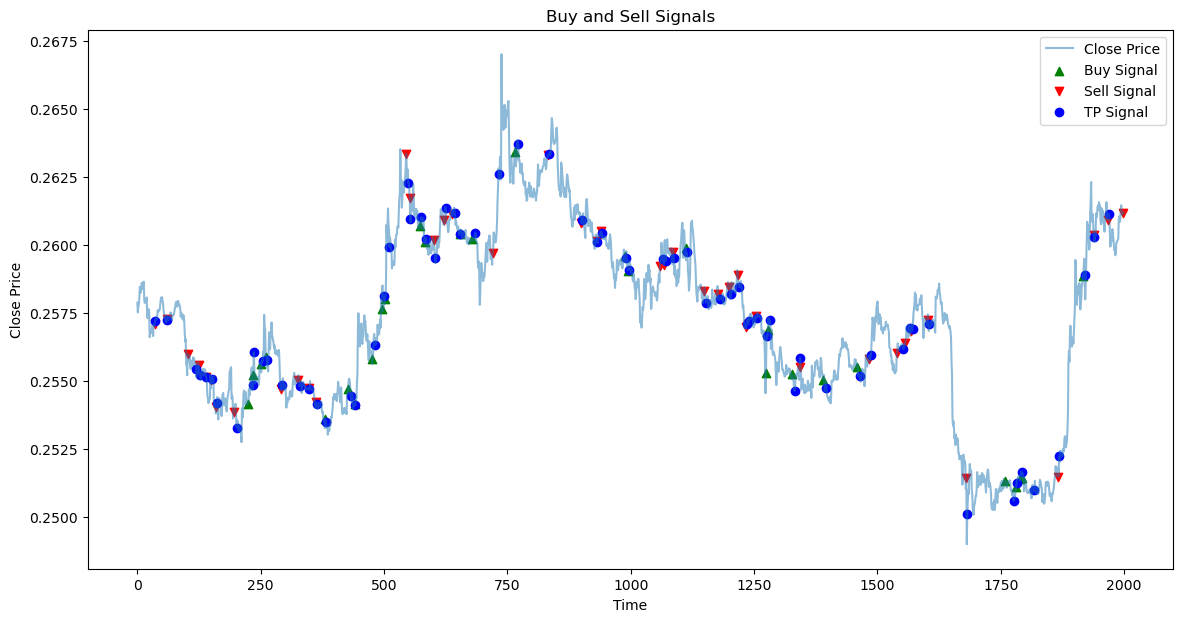

In [14]:
xrp_df_clone = xrp_df.iloc[:2000].copy()


plt.figure(figsize=(14, 7))
plt.plot(xrp_df_clone['close'], label="Close Price", alpha=0.5)
buy_signals = xrp_df_clone[xrp_df_clone['signal'] == "buy"]
sell_signals = xrp_df_clone[xrp_df_clone['signal'] == "sell"]
tp_signals = xrp_df_clone[xrp_df_clone['signal'] == "take profit"]
plt.scatter(buy_signals.index, buy_signals['close'], label="Buy Signal", marker="^", color="green", alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], label="Sell Signal", marker="v", color="red", alpha=1)
plt.scatter(tp_signals.index, tp_signals['close'], label="TP Signal", marker="o", color="blue", alpha=1)
plt.title("Buy and Sell Signals")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()
